## generate image with random PWM values

C:\Users\plasma\AppData\Local\Temp\ipykernel_23328\2668042787.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.array([[pwms], [0], [0], [0], [0]]).astype(int)


The original PWM randomly set by [1853, 0, 0, 0, 0].


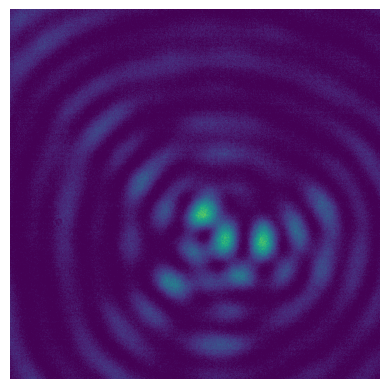

In [1]:
import csv
import numpy as np
import random
import time
from PIL import Image
from imageio import imwrite,imread
import os
from pylablib.devices import Thorlabs
from PIL import Image
import PIL.ImageOps 
import matplotlib.pyplot as plt 
  
from pylablib.devices import Thorlabs
Thorlabs.list_cameras_tlcam()
cam = Thorlabs.ThorlabsTLCamera(serial="14308")
cam.set_exposure(0.0001) # set exposure to 100ms
cam.set_roi(0,1000,0,1000) # set ROI in the upper left corner

import laserbeamsize as lbs
pwms = np.random.randint(low=0,high=4095,size=(1,1), dtype=np.int32)  
A = np.array([[pwms], [0], [0], [0], [0]]).astype(int)
with open('PWM_test.csv', 'w', newline='') as file:
    mywriter = csv.writer(file, delimiter=',')
    mywriter.writerows(A)
raw_image_array = cam.grab(10) # grab 10 frames
image_array_initial=np.array(raw_image_array)
squeezed_image_array=image_array_initial.squeeze()
random_PWM=A
random_PWM_printed=A.ravel().tolist()
print(f"The original PWM randomly set by {random_PWM_printed}.")
plt.axis('off')
plt.imshow(image_array_initial[0])
cam.close()


In [2]:
from scipy import stats
from scipy import optimize
from sklearn.metrics import r2_score
from PIL import Image
import glob
import math
from skimage.filters import sobel

def get_quality_number(squeezed_image_array):
    Score = np.array([])  # Create an empty NumPy array
    for i in range(len(squeezed_image_array)):
        [x_max, y_max] = np.unravel_index(np.argmax(squeezed_image_array[i]), squeezed_image_array[i].shape)
        [m, n] = np.where(squeezed_image_array[i] == round(np.max(squeezed_image_array[i]) / math.exp(1)))
        length = np.sqrt(np.power(abs(m - x_max), 2) + np.power(abs(n - y_max), 2))
        Score = np.append(Score, np.mean(length) / np.max(length))  # Append values to the NumPy array

    return np.mean(Score)  # Calculate the mean of the Score array

# Test your function

s1 = get_quality_number(squeezed_image_array)
print(s1)


0.27800318323207784


In [3]:
def set_PWMs(pwms):
    # Your code that sets the PWMs
    A = np.array([[pwms[0]], [pwms[1]], [pwms[2]], [pwms[3]], [pwms[4]]]).astype(int)
    with open('PWM_test.csv', 'w', newline='') as file:
        mywriter = csv.writer(file, delimiter=',')
        mywriter.writerows(A)
    time.sleep(2)
    return 0

In [4]:
from scipy import stats
from scipy import optimize
from sklearn.metrics import r2_score
from PIL import Image
import glob
from pylablib.devices import Thorlabs
Thorlabs.list_cameras_tlcam()
cam = Thorlabs.ThorlabsTLCamera(serial="14308")
# cam.close()
cam.set_exposure(0.0001) # set exposure to 100ms
# frame = cam.snap() # grab a single frame
cam.set_roi(0,1000,0,1000) # set ROI in the upper left corner

(0, 1000, 0, 1000, 1, 1)

In [5]:
def do_annealing(wait=5*33*0.03):
    # Annealing
    with open('PWM_test.csv', 'r', encoding='utf-8') as pwm_file:
        pwm_data = pwm_file.readlines()
    # Write data to do_annealing.csv
    with open('do_annealing.csv', 'w', encoding='utf-8') as annealing_file:
        annealing_file.writelines(pwm_data)
    time.sleep(wait) # Wait for annealing to complete

In [6]:
def get_quality_number1():

    #take image and calculate the quality number
    raw_image_array = cam.grab(10)    # grab 10 frame
    image_array=np.array(raw_image_array)
    squeezed_image_array=image_array.squeeze()
    score=[]
    for i in range (len(squeezed_image_array)):
        [x_max,y_max] = np.unravel_index(np.argmax(squeezed_image_array[i]), squeezed_image_array[i].shape) 
        [m,n]=np.where(squeezed_image_array[i]==round(np.max(squeezed_image_array[i])/math.exp(1)))
        length = np.sqrt(np.power(abs(m-x_max),2)+np.power(abs(n-y_max),2))
        score.append(np.mean(length)/np.max(length))
    average_score=np.mean(score)
    quality_number = average_score
    return quality_number

In [7]:
# SYNTHESIS and CHARACTERISATION
from OptimizationTestFunctions import Sphere, plot_3d
def set_PWMs_and_get_quality(pwms,sphere_test=False, annealing=False):
    if sphere_test:
        f = Sphere(dim=5,degree=2)
        #return -1*f(pwms)
        return -1*f(pwms)/1000000
    else:
        set_PWMs(pwms)
        quality_number = get_quality_number1()
        time.sleep(1)
        if annealing:
            do_annealing()
        return quality_number

In [8]:
import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.utils import standardize
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import UpperConfidenceBound
from botorch.optim import optimize_acqf
from botorch.models.transforms.input import Normalize
from botorch.models.transforms.outcome import Standardize
from botorch.acquisition import qLogExpectedImprovement

In [9]:
# Random Strategy

import random

def get_random_PWMs():
    random_value = random.randint(0, 4095)
    return [random_value] + [0] * 4
random_PWMs = get_random_PWMs()
print(random_PWMs)

[830, 0, 0, 0, 0]


In [10]:
# Bayesian Opt Strategy

import numpy as np
import pandas as pd

from botorch.acquisition import qExpectedImprovement
from botorch.sampling import SobolQMCNormalSampler

sampler = SobolQMCNormalSampler(sample_shape=torch.Size([512]), seed=0)
torch.manual_seed(seed=0)  # to keep the restart conditions the same    

def calculate_BO_candidate(samples):
    train_X = samples[["p1"]]
    train_Y = samples[["error"]]

    train_X = torch.tensor(train_X.to_numpy(dtype=np.float64))
    train_Y = torch.tensor(train_Y.to_numpy(dtype=np.float64))

    gp = SingleTaskGP(train_X, train_Y, input_transform=Normalize(d=train_X.shape[-1]), outcome_transform=Standardize(m=train_Y.shape[-1]),)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_mll(mll)

    #from botorch.acquisition import UpperConfidenceBound
    #UCB = UpperConfidenceBound(gp, beta=.1)

    MC_EI = qLogExpectedImprovement(gp, best_f=train_Y.max(), sampler=sampler)

    
    from botorch.optim import optimize_acqf
    bounds = torch.stack([torch.zeros(1), torch.ones(1)*4095])
    #bounds = torch.stack([torch.zeros(5), torch.ones(5)*5])

    candidate, acq_value = optimize_acqf(
        MC_EI, bounds=bounds, q=1, num_restarts=5, raw_samples=20,
    )
    candidate = candidate[0]
    return candidate

Optimisation Loop:

In [11]:
import random
import pandas as pd
import time

N_TRIALS = 15
N_ITERATIONS = 100
USE_TEST_FUNCTION =False
USE_ANNEALING =True

best_random_all = []
best_BO_all = []
random_trial_samples = []
BO_trial_samples = []



for trial in range(N_TRIALS):
    print(f"Trial {trial}")
    BO_samples = pd.DataFrame(columns=['p1', 'p2', 'p3', "p4", "p5", 'error', 'trial', "iteration", "timestamp"])
    random_samples = pd.DataFrame(columns=['p1', 'p2', 'p3', "p4", "p5", 'error', 'trial', "iteration", "timestamp"])
    BO_current_candidate = get_random_PWMs()
    random_current_candidate = get_random_PWMs()
    
    best_random = []
    best_BO = []

    for iteration in range(N_ITERATIONS):
        
        print(f"Iteration {iteration} {time.time()}")
        # Random Search
        random_current_quality = set_PWMs_and_get_quality(random_current_candidate, sphere_test=USE_TEST_FUNCTION, annealing=USE_ANNEALING)
        new_sample = {f"p{i+1}": p for i, p in enumerate(random_current_candidate)}
        new_sample["error"] = random_current_quality
        new_sample["timestamp"] = time.time()
        new_sample["trial"] = trial
        new_sample["iteration"] = iteration
        new_sample = pd.DataFrame(new_sample, index=[iteration])
        random_samples = pd.concat([random_samples, new_sample], axis=0, ignore_index=True)
        random_current_candidate = get_random_PWMs()
        
        # Bayesian Optimization
        BO_current_quality = set_PWMs_and_get_quality(BO_current_candidate, sphere_test=USE_TEST_FUNCTION, annealing=USE_ANNEALING)
        new_sample = {f"p{i+1}": p for i, p in enumerate(BO_current_candidate)}
        new_sample["error"] = BO_current_quality
        new_sample["timestamp"] = time.time()
        new_sample["trial"] = trial
        new_sample["iteration"] = iteration
        new_sample = pd.DataFrame(new_sample, index=[iteration])
        BO_samples = pd.concat([BO_samples, new_sample], axis=0, ignore_index=True)
        
        if iteration < 10:
            BO_current_candidate = get_random_PWMs()
        else:
            BO_current_candidate = calculate_BO_candidate(BO_samples)
            BO_current_candidate=[BO_current_candidate[0],0,0,0,0]
#             BO_current_candidate = [torch.round(x) for x in BO_current_candidate]
            BO_current_candidate = [torch.round(x) if isinstance(x, torch.Tensor) else x for x in BO_current_candidate]

        
        best_random.append(random_samples["error"].max())
        best_BO.append(BO_samples["error"].max())
        
    random_trial_samples.append(random_samples.copy(deep=True))
    BO_trial_samples.append(BO_samples.copy(deep=True))
    
    best_random_all.append(best_random)
    best_BO_all.append(best_BO)

    # Print the best BO parameters and value for the current trial
    best_BO_value = max(best_BO)
    best_BO_index = best_BO.index(best_BO_value)
    best_BO_params = BO_trial_samples[trial].loc[best_BO_index, ['p1', 'p2', 'p3', 'p4', 'p5']].tolist()
    print(f"Best BO Parameters (Trial {trial}):", best_BO_params)
    print(f"Best BO Value (Trial {trial}):", best_BO_value)
    print("=" * 30)
import pickle
# open a file, where you ant to store the data
filename = 'results_'+str(time.time())
file = open(filename, 'wb')

# dump information to that file
data = (random_trial_samples, BO_trial_samples, best_random_all, best_BO_all)
pickle.dump(data, file)
# close the file
file.close()



Trial 0
Iteration 0 1694813074.7072904
Iteration 1 1694813093.1363976
Iteration 2 1694813111.5556378
Iteration 3 1694813129.9457245
Iteration 4 1694813148.3656702
Iteration 5 1694813166.795645
Iteration 6 1694813185.2059956
Iteration 7 1694813203.6459749
Iteration 8 1694813222.0359685
Iteration 9 1694813240.4459357
Iteration 10 1694813258.8158934
Iteration 11 1694813277.7957861
Iteration 12 1694813296.4058928
Iteration 13 1694813315.0058675
Iteration 14 1694813333.6159258
Iteration 15 1694813352.2759035
Iteration 16 1694813370.9458752
Iteration 17 1694813389.6371415
Iteration 18 1694813408.3677325
Iteration 19 1694813427.0678198
Iteration 20 1694813445.9177933
Iteration 21 1694813464.537769
Iteration 22 1694813483.198719
Iteration 23 1694813501.8686948
Iteration 24 1694813520.5607522
Iteration 25 1694813539.2691438
Iteration 26 1694813558.0691164
Iteration 27 1694813576.9091017
Iteration 28 1694813595.6071103
Iteration 29 1694813614.311674
Iteration 30 1694813633.2010834
Iteration 31 1

Iteration 51 1694817730.4351065
Iteration 52 1694817748.975082
Iteration 53 1694817767.482388
Iteration 54 1694817786.0223625
Iteration 55 1694817804.52238
Iteration 56 1694817823.052312
Iteration 57 1694817841.5622892
Iteration 58 1694817860.0772097
Iteration 59 1694817878.577189
Iteration 60 1694817897.083341
Iteration 61 1694817915.6232774
Iteration 62 1694817934.1132526
Iteration 63 1694817952.6232224
Iteration 64 1694817971.1231983
Iteration 65 1694817989.6331728
Iteration 66 1694818008.193148
Iteration 67 1694818026.7131257
Iteration 68 1694818045.2089245
Iteration 69 1694818063.7560747
Iteration 70 1694818082.2863014
Iteration 71 1694818100.846332
Iteration 72 1694818119.3571477
Iteration 73 1694818137.8371208
Iteration 74 1694818156.3206303
Iteration 75 1694818174.8551145
Iteration 76 1694818193.4740863
Iteration 77 1694818211.9535306
Iteration 78 1694818230.4806643
Iteration 79 1694818249.0105624
Iteration 80 1694818267.530141
Iteration 81 1694818286.0657308
Iteration 82 16948

Iteration 1 1694822366.4834614
Iteration 2 1694822384.9034374
Iteration 3 1694822403.2834187
Iteration 4 1694822421.683386
Iteration 5 1694822440.1033628
Iteration 6 1694822458.5233364
Iteration 7 1694822476.9333117
Iteration 8 1694822495.3633025
Iteration 9 1694822513.793261
Iteration 10 1694822532.1832356
Iteration 11 1694822550.8031332
Iteration 12 1694822569.4081345
Iteration 13 1694822587.986449
Iteration 14 1694822606.7180552
Iteration 15 1694822625.458038
Iteration 16 1694822644.0280027
Iteration 17 1694822662.5779777
Iteration 18 1694822681.1279469
Iteration 19 1694822699.712709
Iteration 20 1694822718.2526844
Iteration 21 1694822736.8126535
Iteration 22 1694822755.3077052
Iteration 23 1694822773.8376808
Iteration 24 1694822792.39766
Iteration 25 1694822810.9676356
Iteration 26 1694822829.557615
Iteration 27 1694822848.1275787
Iteration 28 1694822866.667559
Iteration 29 1694822885.2375333
Iteration 30 1694822903.7675035
Iteration 31 1694822922.307484
Iteration 32 1694822940.867

Iteration 52 1694827022.3400035
Iteration 53 1694827040.889972
Iteration 54 1694827059.4899466
Iteration 55 1694827078.070087
Iteration 56 1694827096.6770906
Iteration 57 1694827115.2970717
Iteration 58 1694827133.8870394
Iteration 59 1694827152.4557593
Iteration 60 1694827171.0703435
Iteration 61 1694827189.620322
Iteration 62 1694827208.2028062
Iteration 63 1694827226.8327494
Iteration 64 1694827245.3829343
Iteration 65 1694827263.9417064
Iteration 66 1694827282.531972
Iteration 67 1694827301.1493952
Iteration 68 1694827319.7093694
Iteration 69 1694827338.2493436
Iteration 70 1694827356.829325
Iteration 71 1694827375.4092984
Iteration 72 1694827393.9592776
Iteration 73 1694827412.509244
Iteration 74 1694827431.0792174
Iteration 75 1694827449.649193
Iteration 76 1694827468.1719353
Iteration 77 1694827486.7419524
Iteration 78 1694827505.3118837
Iteration 79 1694827523.8618944
Iteration 80 1694827542.4718387
Iteration 81 1694827561.0418441
Iteration 82 1694827579.602114
Iteration 83 169

Iteration 1 1694831650.3079097
Iteration 2 1694831668.7381876
Iteration 3 1694831687.1681604
Iteration 4 1694831705.5681355
Iteration 5 1694831723.9981072
Iteration 6 1694831742.4180908
Iteration 7 1694831760.8280594
Iteration 8 1694831779.2380328
Iteration 9 1694831797.6480105
Iteration 10 1694831816.0479834
Iteration 11 1694831834.6178794
Iteration 12 1694831853.2378492
Iteration 13 1694831871.7978225
Iteration 14 1694831890.4578404
Iteration 15 1694831909.048234
Iteration 16 1694831927.638209
Iteration 17 1694831946.2781808
Iteration 18 1694831964.848331
Iteration 19 1694831983.458295
Iteration 20 1694832002.0082693
Iteration 21 1694832020.6182482
Iteration 22 1694832039.1734812
Iteration 23 1694832057.7234175
Iteration 24 1694832076.2736273
Iteration 25 1694832094.824141
Iteration 26 1694832113.394117
Iteration 27 1694832131.974091
Iteration 28 1694832150.5440636
Iteration 29 1694832169.0962117
Iteration 30 1694832187.6522546
Iteration 31 1694832206.2122228
Iteration 32 1694832224.

Iteration 52 1694836307.9810224
Iteration 53 1694836326.5509999
Iteration 54 1694836345.0909696
Iteration 55 1694836363.6909494
Iteration 56 1694836382.250922
Iteration 57 1694836400.8143704
Iteration 58 1694836419.3969662
Iteration 59 1694836437.9669445
Iteration 60 1694836456.5269172
Iteration 61 1694836475.0568907
Iteration 62 1694836493.6268663
Iteration 63 1694836512.206842
Iteration 64 1694836530.7568192
Iteration 65 1694836549.3267894
Iteration 66 1694836567.8667672
Iteration 67 1694836586.5267367
Iteration 68 1694836605.0467167
Iteration 69 1694836623.676694
Iteration 70 1694836642.2866647
Iteration 71 1694836660.8566375
Iteration 72 1694836679.4166138
Iteration 73 1694836698.046589
Iteration 74 1694836716.6065674
Iteration 75 1694836735.1065402
Iteration 76 1694836753.6919956
Iteration 77 1694836772.3101778
Iteration 78 1694836790.900151
Iteration 79 1694836809.4701297
Iteration 80 1694836828.0201032
Iteration 81 1694836846.580081
Iteration 82 1694836865.130055
Iteration 83 16

In [12]:
BO_trial_samples

[             p1 p2 p3 p4 p5     error trial iteration     timestamp
 0          2516  0  0  0  0  0.229568     0         0  1.694813e+09
 1          3738  0  0  0  0  0.345524     0         1  1.694813e+09
 2          1190  0  0  0  0  0.315504     0         2  1.694813e+09
 3           228  0  0  0  0  0.828183     0         3  1.694813e+09
 4          1093  0  0  0  0  0.267400     0         4  1.694813e+09
 ..          ... .. .. .. ..       ...   ...       ...           ...
 95   tensor(0.)  0  0  0  0  0.484686     0        95  1.694815e+09
 96  tensor(62.)  0  0  0  0  0.405106     0        96  1.694815e+09
 97   tensor(0.)  0  0  0  0  0.435091     0        97  1.694815e+09
 98   tensor(0.)  0  0  0  0  0.423368     0        98  1.694815e+09
 99   tensor(0.)  0  0  0  0  0.434757     0        99  1.694815e+09
 
 [100 rows x 9 columns],
                p1 p2 p3 p4 p5     error trial iteration     timestamp
 0            2884  0  0  0  0  0.458946     1         0  1.694815e+09
 1 

In [13]:
best_BO_all

[[0.22956796070482893,
  0.3455236267479359,
  0.3455236267479359,
  0.8281827351814511,
  0.8281827351814511,
  0.8281827351814511,
  0.8281827351814511,
  0.8281827351814511,
  0.8281827351814511,
  0.8281827351814511,
  0.8281827351814511,
  0.8281827351814511,
  0.8281827351814511,
  0.8281827351814511,
  0.8281827351814511,
  0.8281827351814511,
  0.8409164432020948,
  0.8409164432020948,
  0.8409164432020948,
  0.8409164432020948,
  0.8409164432020948,
  0.8409164432020948,
  0.8409164432020948,
  0.8409164432020948,
  0.8409164432020948,
  0.8409164432020948,
  0.8409164432020948,
  0.8409164432020948,
  0.8409164432020948,
  0.8409164432020948,
  0.8409164432020948,
  0.8409164432020948,
  0.8409164432020948,
  0.8409164432020948,
  0.8409164432020948,
  0.8409164432020948,
  0.8409164432020948,
  0.8409164432020948,
  0.8409164432020948,
  0.8409164432020948,
  0.8409164432020948,
  0.8409164432020948,
  0.8409164432020948,
  0.8409164432020948,
  0.8409164432020948,
  0.84091

## Plot results

In [14]:
filename

'results_1694840912.8432772'

In [15]:
# open a file, where you stored the pickled data
file = open(filename, 'rb')

# dump information to that file
data = pickle.load(file)
random_trial_samples, BO_trial_samples, best_random_all, best_BO_all = data

# close the file
file.close()

print('Showing the pickled data:')

cnt = 0
for item in data:
    print('The data ', cnt, ' is : ', item)
    cnt += 1


Showing the pickled data:
The data  0  is :  [      p1 p2 p3 p4 p5     error trial iteration     timestamp
0   1376  0  0  0  0  0.254571     0         0  1.694813e+09
1   1848  0  0  0  0  0.365474     0         1  1.694813e+09
2   1969  0  0  0  0  0.357243     0         2  1.694813e+09
3    291  0  0  0  0  0.818645     0         3  1.694813e+09
4   1449  0  0  0  0  0.320897     0         4  1.694813e+09
..   ... .. .. .. ..       ...   ...       ...           ...
95   448  0  0  0  0  0.454064     0        95  1.694815e+09
96  1960  0  0  0  0  0.467227     0        96  1.694815e+09
97  2716  0  0  0  0  0.381845     0        97  1.694815e+09
98  4052  0  0  0  0  0.447929     0        98  1.694815e+09
99  3398  0  0  0  0  0.458756     0        99  1.694815e+09

[100 rows x 9 columns],       p1 p2 p3 p4 p5     error trial iteration     timestamp
0   2358  0  0  0  0  0.455553     1         0  1.694815e+09
1    330  0  0  0  0  0.361884     1         1  1.694815e+09
2   2668  0  0

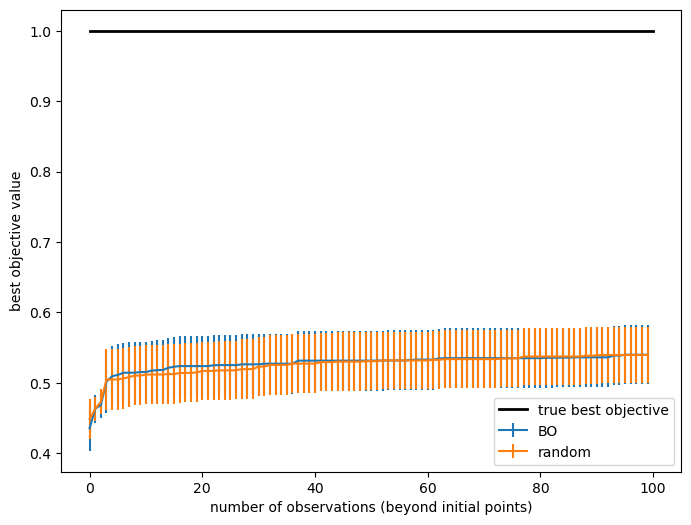

In [16]:
import numpy as np
from matplotlib import pyplot as plt


def ci(y):
    return 1.96 * y.std(axis=0) / np.sqrt(N_TRIALS)

GLOBAL_MAXIMUM = 1
if USE_TEST_FUNCTION:
    GLOBAL_MAXIUM = 0



iters = np.arange(N_ITERATIONS)
y_random = np.asarray(best_random_all)
y_BO = np.asarray(best_BO_all)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.errorbar(iters, y_BO.mean(axis=0), yerr=ci(y_BO), label="BO", linewidth=1.5)
ax.errorbar(iters, y_random.mean(axis=0), yerr=ci(y_random), label="random", linewidth=1.5)
plt.plot(
    [0, N_ITERATIONS],
    [GLOBAL_MAXIMUM] * 2,
    "k",
    label="true best objective",
    linewidth=2,
)
#ax.set_ylim(bottom=0.5)
ax.set(
    xlabel="number of observations (beyond initial points)",
    ylabel="best objective value",
)
ax.legend(loc="lower right")

In [17]:
y_BO

array([[0.22956796, 0.34552363, 0.34552363, ..., 0.84091644, 0.84091644,
        0.84091644],
       [0.45894564, 0.47010638, 0.47010638, ..., 0.49712673, 0.49712673,
        0.49712673],
       [0.41355168, 0.49400185, 0.49400185, ..., 0.50050783, 0.50050783,
        0.50050783],
       ...,
       [0.45949339, 0.46491917, 0.46491917, ..., 0.52338455, 0.52338455,
        0.52338455],
       [0.46101643, 0.46867593, 0.49460372, ..., 0.51949944, 0.51949944,
        0.51949944],
       [0.42117955, 0.46719636, 0.46719636, ..., 0.55692902, 0.55692902,
        0.55692902]])

In [18]:
y_random

array([[0.25457072, 0.36547356, 0.36547356, ..., 0.83043957, 0.83043957,
        0.83043957],
       [0.45555279, 0.45555279, 0.45555279, ..., 0.51147242, 0.51147242,
        0.51147242],
       [0.45816406, 0.45816406, 0.45816406, ..., 0.51810067, 0.51810067,
        0.51810067],
       ...,
       [0.49398104, 0.49398104, 0.49398104, ..., 0.52944087, 0.52944087,
        0.52944087],
       [0.44118396, 0.46608152, 0.51259549, ..., 0.554302  , 0.554302  ,
        0.554302  ],
       [0.4555726 , 0.4714453 , 0.4714453 , ..., 0.53523966, 0.53523966,
        0.53523966]])

In [19]:
cam.close()

In [20]:
from pylablib.devices import Thorlabs
Thorlabs.list_cameras_tlcam()
cam = Thorlabs.ThorlabsTLCamera(serial="14308")
cam.set_exposure(0.0001) # set exposure to 100ms
cam.set_roi(0,1000,0,1000) # set ROI in the upper left corner

import laserbeamsize as lbs
A0 = np.array([[random_PWM[0]], [random_PWM[1]], [random_PWM[2]], [random_PWM[3]], [random_PWM[4]]])
with open('PWM_test.csv', 'w', newline='') as file:
    mywriter = csv.writer(file, delimiter=',')
    mywriter.writerows(A0)
print(f"The original PWM randomly set by {random_PWM_printed} with score {s1}")

optimal_pwm_values=best_BO_params
A1= np.array([[optimal_pwm_values[0]], [optimal_pwm_values[1]], [optimal_pwm_values[2]], [optimal_pwm_values[3]], [optimal_pwm_values[4]]])
with open('PWM_test.csv', 'w', newline='') as file:
    mywriter = csv.writer(file, delimiter=',')
    mywriter.writerows(A1)
raw_image_array1 = cam.grab(10) # grab 10 frames
image_array1=np.array(raw_image_array1)
squeezed_image_array1=image_array1.squeeze()
print(f"The suggested PWM values for correction is {optimal_pwm_values} with score {best_BO_value}")
cam.close()

The original PWM randomly set by [1853, 0, 0, 0, 0] with score 0.27800318323207784
The suggested PWM values for correction is [tensor(61.), 0, 0, 0, 0] with score 0.5569290239700756


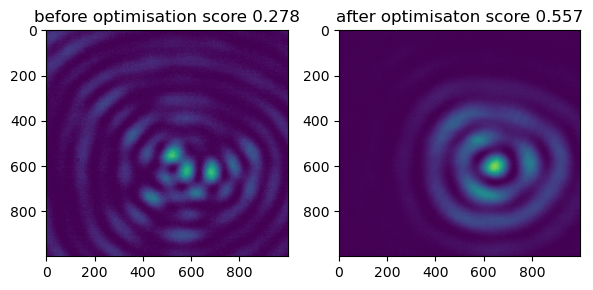

In [21]:
rows = 1
columns = 2
fig, (ax1, ax2) = plt.subplots(nrows=rows, ncols=columns, figsize=(columns*3, rows*3))
ax1.imshow(image_array_initial[0], aspect='auto')
ax1.set_title(f'before optimisation score {s1:.3f}')
ax2.imshow(image_array1[0], aspect='auto')
ax2.set_title(f'after optimisaton score {best_BO_value:.3f}')
fig.tight_layout() # used to adjust padding between subplots 

In [22]:
cam.close()

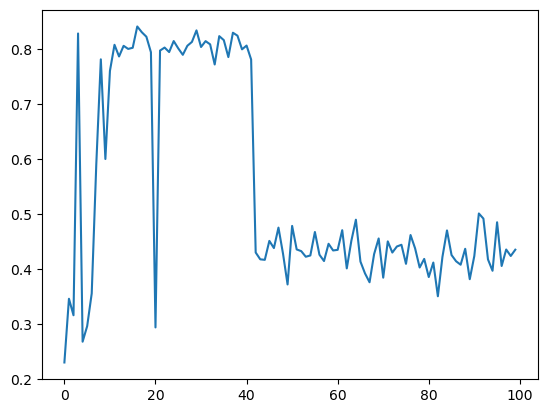

In [23]:
plt.plot(BO_trial_samples[0]["error"])